# Boulder 2017 B-cycle Trip Data Exploration

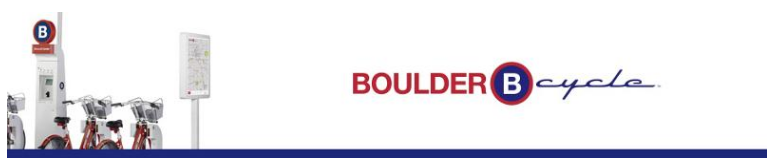

In [183]:
from IPython.display import Image
image = Image('figures/Boulder Header.png')
image

## 1. Introduction

[Boulder B-cycle](https://boulder.bcycle.com/) is a nonprofit organization formed by Boulder residents to create and operate Boulder’s bike-sharing program on a not-for-profit, financially sustainable basis. Its mission is to “implement and operate a community-supported bike-share program that provides Boulder’s residents, commuters and visitors with an environmentally friendly, financially sustainable, and affordable transportation option that’s ideal for short trips resulting in fewer vehicle miles traveled, less pollution and congestion, more personal mobility and better health and wellness.”

## 2. The Datasets

The dataset is in an Excel .xlsx format and is a 30 MB file. It contains data from May 2011 to January 2017. For the purpose of this exercise only rows for 2017 were kept.

In [184]:
# import necessary libraries and modules
import pandas as pd
import numpy as np
from numpy import datetime64
import csv
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

In [185]:
# taken from Brandon Rhodes's Pandas Tutorial (https://github.com/brandon-rhodes)
from IPython.core.display import HTML
css = open('data/style-table.css').read() + open('data/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [186]:
# read converted csv compressed file
dF = pd.read_csv("data/Boulder_2017_Bike_Trip_Data.gz", dtype = {'Bike_Number' : object}, compression="gzip")

### Trips dataframe data structure

Trips dataframe has 11 columns, two int64 and 10 object data types. The column names were updated in 
Boulder_2017_Excel_to_CSV_File_Conversion.ipynb
The original columns in the Excel file were ('Rider Home System' , 'Rider or Operator Number', 'Entry Pass Type',
'Bike Number', 'Checkout Date', 'Checkout Day of Week', 'Checkout Time', 'Checkout Station', 'Return Date',
'Return Day of Week', 'Return Time', 'Return Station', 'Trip Duration (Minutes)')

In [187]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122331 entries, 0 to 122330
Data columns (total 11 columns):
User_Program       122331 non-null object
User_ID            122331 non-null object
Membership_Type    122305 non-null object
Bike_Number        122331 non-null object
Checkout_Date      122331 non-null object
Checkout_Time      122331 non-null object
Checkout_Kiosk     122331 non-null object
Return_Date        122331 non-null object
Return_Time        122331 non-null object
Return_Kiosk       122318 non-null object
Trip_Duration      122331 non-null int64
dtypes: int64(1), object(10)
memory usage: 10.3+ MB


### Estimated number of trips = 122,331

In [188]:
# main dataframe has 122,331 rows of data
dF.shape

(122331, 11)

### Remove rows with NULL values in ANY column

In [189]:
dF.isnull().values.any()

True

In [190]:
nan_rows = dF[dF.isnull().T.any().T]

In [191]:
nan_rows.head()

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration
2162,Boulder B-cycle,M9999926,Maintenance,2,2017-01-19,12:17:00,14th & Canyon,00:00:00,00:00:00,NaN,0
2184,Boulder B-cycle,M9999926,Maintenance,8,2017-01-19,12:25:00,14th & Canyon,00:00:00,00:00:00,NaN,0
2437,Nashville B-cycle,R1070952,NaN,518,2017-01-20,13:07:00,13th & Spruce,2017-01-20 00:00:00,13:28:00,13th & College,21
2751,Boulder B-cycle,R1052386,Annual,708,2017-01-21,20:17:00,28th & Boulder Creek,00:00:00,00:00:00,NaN,0
4497,Boulder B-cycle,M9999920,Maintenance,558,2017-01-31,09:49:00,30th & Marine,00:00:00,00:00:00,NaN,0


In [192]:
nan_rows.shape

(39, 11)

In [193]:
dF = dF.drop(dF.index[nan_rows.index])

### Estimated number of trips = 122,292

In [194]:
dF.shape

(122292, 11)

In [195]:
dF.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration
0,Boulder B-cycle,R1094717,Annual,913,2017-01-01,00:08:00,13th & Spruce,2017-01-01 00:00:00,00:13:00,Broadway & Alpine,5
1,Boulder B-cycle,R1066072,Annual,938,2017-01-01,00:08:00,13th & Spruce,2017-01-01 00:00:00,00:13:00,Broadway & Alpine,5
2,Boulder B-cycle,R1004330,Annual,745,2017-01-01,00:15:00,11th & Pearl,2017-01-01 00:00:00,00:29:00,11th & Pearl,14


### Convert Checkout_Date and Return_Date columns to DateTime datatype

In [196]:
dF['Checkout_Date'] = pd.to_datetime(dF['Checkout_Date'])
dF['Return_Date'] = pd.to_datetime(dF['Return_Date'])

In [197]:
dF.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration
0,Boulder B-cycle,R1094717,Annual,913,2017-01-01,00:08:00,13th & Spruce,2017-01-01,00:13:00,Broadway & Alpine,5
1,Boulder B-cycle,R1066072,Annual,938,2017-01-01,00:08:00,13th & Spruce,2017-01-01,00:13:00,Broadway & Alpine,5
2,Boulder B-cycle,R1004330,Annual,745,2017-01-01,00:15:00,11th & Pearl,2017-01-01,00:29:00,11th & Pearl,14


## 3. Data Wrangling

### Filtering the main dataframe to obtain actual miles ridden

### Checkouts Per Membership Type

In [198]:
# Checkouts by Membership Type
membership = dF.groupby('Membership_Type').size().sort_values(ascending=False)

In [199]:
# there are 15,393 rows with Membership = Maintenance, a significant 12.5%
membership.head(10)

Membership_Type
Annual          67092
24-hour         23082
Maintenance     15393
Monthly         14426
Pay-per-trip     2293
7-day               6
dtype: int64

In [200]:
# https://jakevdp.github.io/PythonDataScienceHandbook/04.11-settings-and-stylesheets.html
IPython_default = plt.rcParams.copy()
from matplotlib import cycler
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

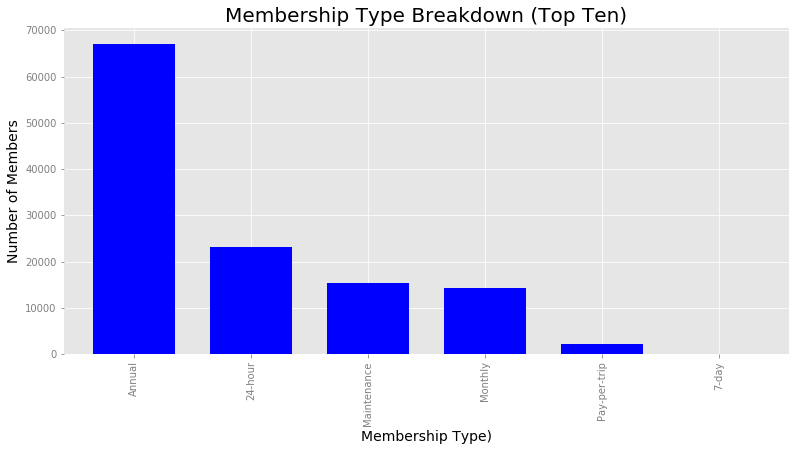

In [201]:
# plot the results
ax = dF.groupby('Membership_Type').size().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title('Membership Type Breakdown (Top Ten)', fontsize = 20)
plt.xlabel('Membership Type)', fontsize = 14)
plt.ylabel('Number of Members', fontsize = 14)
plt.show()

In [202]:
# cannot use "Maintenance" to count toward total distance ridden
dF = dF[dF.Membership_Type != 'Maintenance']

### Estimated number of trips = 106,899

In [203]:
dF.shape

(106899, 11)

### Keep a copy of the dataframe for use in Regression studies

In [204]:
dML = dF.copy(deep=True)

### Estimated number of trips = 104,985

In [205]:
# Check to see number of trips made with 0 minutes
tripDurZero = dF[(dF['Trip_Duration'] == 0)]
tripDurZero.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1914 entries, 156 to 122265
Data columns (total 11 columns):
User_Program       1914 non-null object
User_ID            1914 non-null object
Membership_Type    1914 non-null object
Bike_Number        1914 non-null object
Checkout_Date      1914 non-null datetime64[ns]
Checkout_Time      1914 non-null object
Checkout_Kiosk     1914 non-null object
Return_Date        1914 non-null datetime64[ns]
Return_Time        1914 non-null object
Return_Kiosk       1914 non-null object
Trip_Duration      1914 non-null int64
dtypes: datetime64[ns](2), int64(1), object(8)
memory usage: 179.4+ KB


In [206]:
# cannot use Trip Duration = 0 to count toward total distance ridden
dF = dF[dF.Trip_Duration != 0]

In [207]:
dF.shape

(104985, 11)

In [208]:
# Check to see number of trips made with 1 minute
tripDurOne = dF[(dF["Checkout_Kiosk"] == dF["Return_Kiosk"]) & (dF["Trip_Duration"] == 1)]
tripDurOne.shape

(1284, 11)

In [209]:
# Check to see number of trips made with 15 minutes or less
dX = dF[(dF["Checkout_Kiosk"] == dF["Return_Kiosk"]) & (dF["Trip_Duration"] < 16)]
dX.shape

(3216, 11)

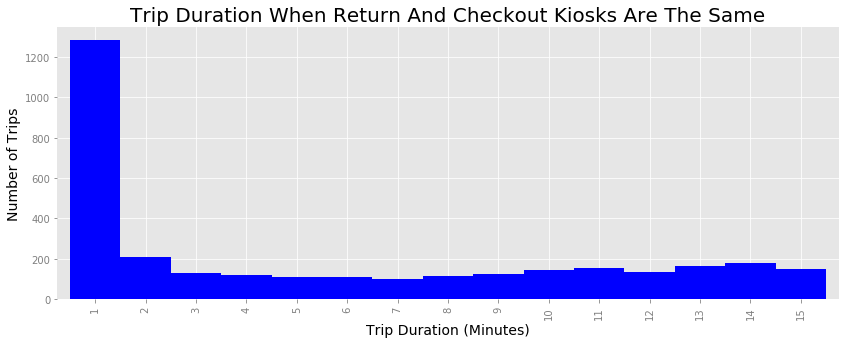

In [210]:
# plot the results
ax = dX.groupby('Trip_Duration').size().plot(kind='bar', figsize=(14,5), color='blue', width=1.0, xlim=(0,16))
plt.title('Trip Duration When Return And Checkout Kiosks Are The Same', fontsize = 20)
plt.xlabel('Trip Duration (Minutes)', fontsize = 14)
plt.ylabel('Number of Trips', fontsize = 14)
#plt.grid(color='w', linestyle='solid')
plt.show()

### Estimated number of trips = 103,578

In [211]:
# remove rows that have a trip duration of 1 minute
dF.drop(dF[dF['Trip_Duration'] == 1].index, inplace = True)

In [212]:
# main dataframe has 103,578 rows to work with, a reduction of 1,407 data rows
dF.shape

(103578, 11)

In [213]:
# Checkouts by Membership Type
membership = dF.groupby('Membership_Type').size().sort_values(ascending=False)
membership.head(10)

Membership_Type
Annual          64842
24-hour         22466
Monthly         14032
Pay-per-trip     2232
7-day               6
dtype: int64

In [214]:
# remove rows that have Return Kiosk = Maintenance
dF.drop(dF[dF['Return_Kiosk'] == 'Maintenance'].index, inplace = True)

In [215]:
# main dataframe has 103,578 rows to work with, a reduction of 1,407 data rows
dF.shape

(103282, 11)

In [216]:
# Checkouts by Membership Type
membership = dF.groupby('Membership_Type').size().sort_values(ascending=False)
membership.head(10)

Membership_Type
Annual          64646
24-hour         22409
Monthly         13996
Pay-per-trip     2225
7-day               6
dtype: int64

### Load Kiosk public data, modify column names

The Kiosk Excel file has names, addresses and geopgraphical coordinates of the 43 Checkout and Return Kiosks. This file needs to be prepared for use with additional code to retrieve distances between Kiosks using the Google Distance Matrix API. This service requires the user to obtain a key that is used to retrieve up to a maximum of 2500 calls per day.

Kiosk dataframe has 10 columns, two int64 and 10 object data types. The column names were updated in Boulder_2017_Excel_to_CSV_File_Conversion.ipynb The original columns in the Excel file were ('Rider Home System' , 'Rider or Operator Number', 'Entry Pass Type', 'Bike Number', 'Checkout Date', 'Checkout Day of Week', 'Checkout Time', 'Checkout Station', 'Return Date', 'Return Day of Week', 'Return Time', 'Return Station', 'Trip Duration (Minutes)')

In [217]:
# read in Kiosk information from file modified in 
dC = pd.read_csv("data/Boulder_2017_Bike_Kiosks_Info.gz", compression="gzip")

In [218]:
dC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 10 columns):
Checkout_Kiosk                 47 non-null object
Return_Kiosk                   47 non-null object
Checkout_Kiosk_Latitude        47 non-null float64
Checkout_Kiosk_Longitude       47 non-null float64
Return_Kiosk_Latitude          47 non-null float64
Return_Kiosk_Longitude         47 non-null float64
Power_Source                   47 non-null object
Installation_Date              47 non-null object
Removal_Date                   47 non-null object
Most_Recent_Number_Of_Docks    47 non-null int64
dtypes: float64(4), int64(1), object(5)
memory usage: 3.8+ KB


In [219]:
dC.shape

(47, 10)

In [220]:
# don't need Power Source, Installation Date, Removal Date and Most Recent Number Of Docks columnns
# retrieving distances from Google Distance API
dC.drop(['Power_Source', 'Installation_Date', 'Removal_Date', 'Most_Recent_Number_Of_Docks'], axis = 1, inplace=True)

In [221]:
# Remove 10th & Walnut, 33rd & Fisher and Wilderness Place Stations (not active in 2017)
dC = dC[dC.Checkout_Kiosk != '10th & Walnut']
dC = dC[dC.Checkout_Kiosk != '33rd & Fisher']
dC = dC[dC.Checkout_Kiosk != 'Wilderness Place']

In [222]:
dC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 1 to 46
Data columns (total 6 columns):
Checkout_Kiosk              44 non-null object
Return_Kiosk                44 non-null object
Checkout_Kiosk_Latitude     44 non-null float64
Checkout_Kiosk_Longitude    44 non-null float64
Return_Kiosk_Latitude       44 non-null float64
Return_Kiosk_Longitude      44 non-null float64
dtypes: float64(4), object(2)
memory usage: 2.4+ KB


### Save Kiosk data for use with Google Distance Matrix API

File is ready for use with additional python/pandas code (Boulder_2017_Bike_Share_Distance_Duration_Submit.py) to retrieve distances between Kiosks using the Google Distance Matrix API. The retrieved distances are saved in (Boulder_Bike_Kiosks_Distances_Durations.csv).

In [223]:
# save dataframe to csv file for use in getting distances from Googe Distance API
dC.to_csv('data/Boulder_2017_Bike_Kiosks_Details.csv', index = False)

### Retrieve Kiosk distances and add Kiosks that have the same starting and ending trip information

File is ready for merging with the Trips dataframe in order to calculate the total miles ridden. But prior to this, 44 more data rows where the Checkout Kiosk and the Return Kiosk are the same have to added to the retrieved file that has distances retrieved from Google. These 44 rows will have the Trip_Distance column reporting zeros but there could be bikes rented from the Checkout Kiosk and returned to it which is considered valid data.

In [224]:
# read in distance information retrieved from Google Distance API
dK = pd.read_csv('data/Boulder_2017_Bike_Kiosks_Distances_Durations.csv')

In [225]:
dK.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1892 entries, 0 to 1891
Data columns (total 12 columns):
Checkout_Kiosk              1892 non-null object
Checkout_Kiosk_Latitude     1892 non-null float64
Checkout_Kiosk_Longitude    1892 non-null float64
Return_Kiosk                1892 non-null object
Return_Kiosk_Latitude       1892 non-null float64
Return_Kiosk_Longitude      1892 non-null float64
Distance_Checkout_Return    1892 non-null float64
Duration_Checkout_Return    1892 non-null float64
Distance_Return_Checkout    1892 non-null float64
Duration_Return_Checkout    1892 non-null float64
Average_Distance            1892 non-null float64
Average_Duration            1892 non-null float64
dtypes: float64(10), object(2)
memory usage: 177.5+ KB


In [226]:
# Drop columns that are not relevant for merging with the Trips dataframe
dK.drop(['Checkout_Kiosk_Latitude', 'Checkout_Kiosk_Longitude', 'Return_Kiosk_Latitude', 'Return_Kiosk_Longitude',
         'Distance_Checkout_Return', 'Duration_Checkout_Return', 'Distance_Return_Checkout',
         'Duration_Return_Checkout', 'Average_Duration'], axis = 1, inplace = True)

In [227]:
dK.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1892 entries, 0 to 1891
Data columns (total 3 columns):
Checkout_Kiosk      1892 non-null object
Return_Kiosk        1892 non-null object
Average_Distance    1892 non-null float64
dtypes: float64(1), object(2)
memory usage: 44.4+ KB


In [228]:
dK.head()

,Checkout_Kiosk,Return_Kiosk,Average_Distance
0,11th & Pearl,13th & Arapahoe,0.585
1,11th & Pearl,13th & College,1.115
2,11th & Pearl,13th & Spruce,0.285
3,11th & Pearl,14th & Canyon,0.660
4,11th & Pearl,15th & Pearl,0.435


In [229]:
# read csv file for use in Trip Distance calculation
dCR = pd.read_csv("data/Boulder_2017_Bike_Kiosks_Info.gz", compression="gzip")

In [230]:
dCR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 10 columns):
Checkout_Kiosk                 47 non-null object
Return_Kiosk                   47 non-null object
Checkout_Kiosk_Latitude        47 non-null float64
Checkout_Kiosk_Longitude       47 non-null float64
Return_Kiosk_Latitude          47 non-null float64
Return_Kiosk_Longitude         47 non-null float64
Power_Source                   47 non-null object
Installation_Date              47 non-null object
Removal_Date                   47 non-null object
Most_Recent_Number_Of_Docks    47 non-null int64
dtypes: float64(4), int64(1), object(5)
memory usage: 3.8+ KB


In [231]:
# Remove 10th & Walnut, 33rd & Fisher and Wilderness Place Stations (not active in 2017)
dCR = dCR[dCR.Checkout_Kiosk != '10th & Walnut']
dCR = dCR[dCR.Checkout_Kiosk != '33rd & Fisher']
dCR = dCR[dCR.Checkout_Kiosk != 'Wilderness Place']

In [232]:
# don't need Power Source, Installation Date, Removal Date and Most Recent Number Of Docks columnns
# retrieving distances from Google Distance API
dCR.drop(['Power_Source', 'Installation_Date', 'Removal_Date', 'Most_Recent_Number_Of_Docks'], axis = 1, inplace=True)

In [233]:
dCR.head(3)

,Checkout_Kiosk,Return_Kiosk,Checkout_Kiosk_Latitude,Checkout_Kiosk_Longitude,Return_Kiosk_Latitude,Return_Kiosk_Longitude
1,11th & Pearl,11th & Pearl,40.018,-105.281,40.018,-105.281
2,13th & Arapahoe,13th & Arapahoe,40.015,-105.278,40.015,-105.278
3,13th & College,13th & College,40.007,-105.277,40.007,-105.277


In [234]:
# Drop columns that are not relevant
dCR.drop(['Checkout_Kiosk_Longitude', 'Checkout_Kiosk_Latitude', 'Return_Kiosk_Longitude', 'Return_Kiosk_Latitude'],
        axis = 1, inplace = True)

In [235]:
# add Average_Distance column and fill with zeros
dCR['Average_Distance'] = 0

In [236]:
dCR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 1 to 46
Data columns (total 3 columns):
Checkout_Kiosk      44 non-null object
Return_Kiosk        44 non-null object
Average_Distance    44 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.4+ KB


In [237]:
dCR.head(3)

,Checkout_Kiosk,Return_Kiosk,Average_Distance
1,11th & Pearl,11th & Pearl,0
2,13th & Arapahoe,13th & Arapahoe,0
3,13th & College,13th & College,0


In [238]:
dCR.shape

(44, 3)

In [239]:
# add these rows to the retrieved distances dataframe
dK = pd.concat([dK, dCR], axis = 0)

In [240]:
# save csv file in preparation for use in the Machine Learning phase
dK.to_csv("data/dK.csv", index=False)

In [241]:
# A combination of 44 Checkout and Return Kiosks should give a value of 1936
dK.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1936 entries, 0 to 46
Data columns (total 3 columns):
Checkout_Kiosk      1936 non-null object
Return_Kiosk        1936 non-null object
Average_Distance    1936 non-null float64
dtypes: float64(1), object(2)
memory usage: 60.5+ KB


In [242]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103282 entries, 0 to 122330
Data columns (total 11 columns):
User_Program       103282 non-null object
User_ID            103282 non-null object
Membership_Type    103282 non-null object
Bike_Number        103282 non-null object
Checkout_Date      103282 non-null datetime64[ns]
Checkout_Time      103282 non-null object
Checkout_Kiosk     103282 non-null object
Return_Date        103282 non-null datetime64[ns]
Return_Time        103282 non-null object
Return_Kiosk       103282 non-null object
Trip_Duration      103282 non-null int64
dtypes: datetime64[ns](2), int64(1), object(8)
memory usage: 9.5+ MB


### Merge with Trips dataframe and remove invalid rows

In [243]:
# merge distance information retrieved from Google Distance API with Trips dataframe
dF = pd.merge(dF, dK, how='left', left_on=['Checkout_Kiosk', 'Return_Kiosk'], right_on=['Checkout_Kiosk', 'Return_Kiosk'])

In [244]:
# Trips dataframe now has 103578 rows, but the Average_Distance column shows only 103282 rows of valid data. This may be
# as a result of some invalid kiosk entries in the Trips dataframe
dF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103282 entries, 0 to 103281
Data columns (total 12 columns):
User_Program        103282 non-null object
User_ID             103282 non-null object
Membership_Type     103282 non-null object
Bike_Number         103282 non-null object
Checkout_Date       103282 non-null datetime64[ns]
Checkout_Time       103282 non-null object
Checkout_Kiosk      103282 non-null object
Return_Date         103282 non-null datetime64[ns]
Return_Time         103282 non-null object
Return_Kiosk        103282 non-null object
Trip_Duration       103282 non-null int64
Average_Distance    103282 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(1), object(8)
memory usage: 10.2+ MB


In [245]:
dF.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Average_Distance
0,Boulder B-cycle,R1094717,Annual,913,2017-01-01,00:08:00,13th & Spruce,2017-01-01,00:13:00,Broadway & Alpine,5,0.505
1,Boulder B-cycle,R1066072,Annual,938,2017-01-01,00:08:00,13th & Spruce,2017-01-01,00:13:00,Broadway & Alpine,5,0.505
2,Boulder B-cycle,R1004330,Annual,745,2017-01-01,00:15:00,11th & Pearl,2017-01-01,00:29:00,11th & Pearl,14,0.000


In [246]:
# Check to confirm there are null values in the dataframe
dF.isnull().values.any()

False

In [247]:
# locate the rows with null data 
nan_rows = dF[dF.isnull().T.any().T]

In [248]:
# This shows 9526 invalid kiosks (e.g. Maintenance)
nan_rows.shape

(0, 12)

In [249]:
nan_rows.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Average_Distance


In [250]:
# remove these 9526 rows from the dataframe
dF = dF.drop(dF.index[nan_rows.index])

### Final number of trips = 103,282

In [251]:
# Main dataframe now has 92,587 rows to work with
dF.shape

(103282, 12)

In [252]:
# Checkouts by Membership Type
membership = dF.groupby('Membership_Type').size().sort_values(ascending=False)
membership

Membership_Type
Annual          64646
24-hour         22409
Monthly         13996
Pay-per-trip     2225
7-day               6
dtype: int64

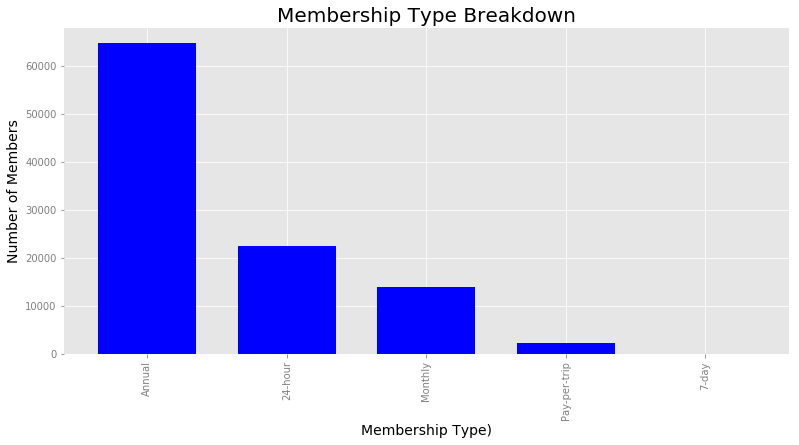

In [253]:
# plot the results
ax = dF.groupby('Membership_Type').size().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title('Membership Type Breakdown', fontsize = 20)
plt.xlabel('Membership Type)', fontsize = 14)
plt.ylabel('Number of Members', fontsize = 14)
plt.show()

### Estimate Trip Distance for Kiosks that have the same starting and ending trip information

In [254]:
dF.rename(columns = {'Average_Distance' : 'Trip_Distance'}, inplace = True)

In [255]:
dF.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance
0,Boulder B-cycle,R1094717,Annual,913,2017-01-01,00:08:00,13th & Spruce,2017-01-01,00:13:00,Broadway & Alpine,5,0.505
1,Boulder B-cycle,R1066072,Annual,938,2017-01-01,00:08:00,13th & Spruce,2017-01-01,00:13:00,Broadway & Alpine,5,0.505
2,Boulder B-cycle,R1004330,Annual,745,2017-01-01,00:15:00,11th & Pearl,2017-01-01,00:29:00,11th & Pearl,14,0.000


In [256]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103282 entries, 0 to 103281
Data columns (total 12 columns):
User_Program       103282 non-null object
User_ID            103282 non-null object
Membership_Type    103282 non-null object
Bike_Number        103282 non-null object
Checkout_Date      103282 non-null datetime64[ns]
Checkout_Time      103282 non-null object
Checkout_Kiosk     103282 non-null object
Return_Date        103282 non-null datetime64[ns]
Return_Time        103282 non-null object
Return_Kiosk       103282 non-null object
Trip_Duration      103282 non-null int64
Trip_Distance      103282 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(1), object(8)
memory usage: 10.2+ MB


In [257]:
# Valid data that needs to aggregated to total distance
dD = dF[(dF["Checkout_Kiosk"] == dF["Return_Kiosk"]) & (dF["Trip_Distance"] == 0)]

In [258]:
# valid data rows = 9230
dD.shape

(9230, 12)

In [259]:
dD.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance
2,Boulder B-cycle,R1004330,Annual,745,2017-01-01,00:15:00,11th & Pearl,2017-01-01,00:29:00,11th & Pearl,14,0.000
5,Boulder B-cycle,R1042539,24-hour,559,2017-01-01,00:21:00,11th & Pearl,2017-01-01,00:35:00,11th & Pearl,14,0.000
46,Boulder B-cycle,R1014838,Monthly,725,2017-01-01,11:21:00,9th & Pearl,2017-01-01,11:36:00,9th & Pearl,15,0.000


In [260]:
dD['Trip_Duration'].sum()

500417

In [261]:
dF['Trip_Duration'].sum() - dD['Trip_Duration'].sum()

1868216

In [262]:
dF['Trip_Distance'].sum()

124730.09

### Estimate average speed for use in Kiosks that have the same and ending trip infomation

In [263]:
avSpeed =  (dF['Trip_Distance'].sum()) /(dF['Trip_Duration'].sum() - dD['Trip_Duration'].sum())

In [264]:
avSpeed # miles/min

0.06676427672174952

In [265]:
dE = dD.copy(deep=True)

In [266]:
# Multiply the trip duration by average speed to get distance
dE['Trip_Distance'] = dE['Trip_Duration'].map(lambda x: x*avSpeed)

In [267]:
# drop columns that are not relevant to the merge with the Trips dataframe
dE.drop(dE.columns[[0,1,2,3,4,5,6,7,8,9,10]], axis=1, inplace=True)

In [268]:
dE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9230 entries, 2 to 103279
Data columns (total 1 columns):
Trip_Distance    9230 non-null float64
dtypes: float64(1)
memory usage: 144.2 KB


In [269]:
# merge the 9230 rows into the 103,282 rows of the main dataframe
dF = pd.merge(dF, dE, how = 'left', left_index=True, right_index= True)

In [270]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103282 entries, 0 to 103281
Data columns (total 13 columns):
User_Program       103282 non-null object
User_ID            103282 non-null object
Membership_Type    103282 non-null object
Bike_Number        103282 non-null object
Checkout_Date      103282 non-null datetime64[ns]
Checkout_Time      103282 non-null object
Checkout_Kiosk     103282 non-null object
Return_Date        103282 non-null datetime64[ns]
Return_Time        103282 non-null object
Return_Kiosk       103282 non-null object
Trip_Duration      103282 non-null int64
Trip_Distance_x    103282 non-null float64
Trip_Distance_y    9230 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1), object(8)
memory usage: 16.0+ MB


In [271]:
dF.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance_x,Trip_Distance_y
0,Boulder B-cycle,R1094717,Annual,913,2017-01-01,00:08:00,13th & Spruce,2017-01-01,00:13:00,Broadway & Alpine,5,0.505,nan
1,Boulder B-cycle,R1066072,Annual,938,2017-01-01,00:08:00,13th & Spruce,2017-01-01,00:13:00,Broadway & Alpine,5,0.505,nan
2,Boulder B-cycle,R1004330,Annual,745,2017-01-01,00:15:00,11th & Pearl,2017-01-01,00:29:00,11th & Pearl,14,0.000,0.935


In [272]:
# convert the NaN values to numeric and fill them with zeros
dF[['Trip_Distance_y']] = dF[['Trip_Distance_y']].apply(pd.to_numeric)
dF['Trip_Distance_y'].fillna(0, inplace=True)

In [273]:
# update the distance values in the main dataframe
dF['Trip_Distance'] = dF['Trip_Distance_x'] + dF['Trip_Distance_y']

In [274]:
dF.drop(['Trip_Distance_x'], axis = 1, inplace=True)

In [275]:
dF.drop(['Trip_Distance_y'], axis = 1, inplace=True)

In [276]:
totalDistance = dF['Trip_Distance'].sum()

### Distance Traveled = 158,140 miles

Boulder Bike Sharing 2017 Annual Report records estimated miles ridden = **242,004**. This report shows **158,140** miles ridden, a delta of **83,864** or **35%**.

In [277]:
totalDistance

158140.0690642677

### Most Popular Checkout Kiosks

In [278]:
# Most popular Checkout Kiosks
mostPopular = dF.groupby('Checkout_Kiosk').size().sort_values(ascending=False)

In [279]:
mostPopular.head(10)

Checkout_Kiosk
Folsom & Colorado       4885
15th & Pearl            4709
28th & Mapleton         4069
Broadway & Euclid       3854
21st & Arapahoe         3462
13th & Spruce           3447
Folsom & Pearl          3416
11th & Pearl            3348
19th @ Boulder Creek    3185
13th & Arapahoe         3143
dtype: int64

### Most Popular Checkout Kiosk to Return Kiosk Routes

In [280]:
cK_rK = dF.groupby(['Checkout_Kiosk', 'Return_Kiosk']).size().to_frame(name = 'Number_Of_Trips').reset_index()

In [281]:
cK_rK.sort_values(by='Number_Of_Trips', ascending=[False]).head(10)

,Checkout_Kiosk,Return_Kiosk,Number_Of_Trips
402,26th @ Pearl,28th & Mapleton,884
520,28th & Mapleton,26th @ Pearl,883
1281,Folsom & Pearl,15th & Pearl,610
44,13th & Arapahoe,13th & Arapahoe,525
1509,Settlers' Park,11th & Pearl,473
830,38th & Arapahoe,48th & Arapahoe,452
355,21st & Arapahoe,21st & Arapahoe,451
246,15th & Pearl,Folsom & Pearl,432
228,15th & Pearl,28th & Mapleton,413
1107,Broadway & Baseline,Williams Village,412


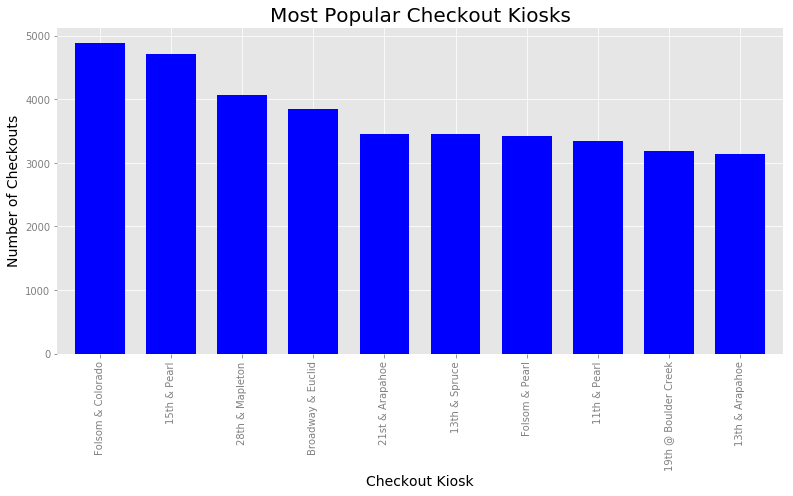

In [282]:
# plot the results
ax = dF.groupby('Checkout_Kiosk').size().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title("Most Popular Checkout Kiosks", fontsize = 20)
plt.xlabel('Checkout Kiosk', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

### Map of Checkout Kiosk Popularity

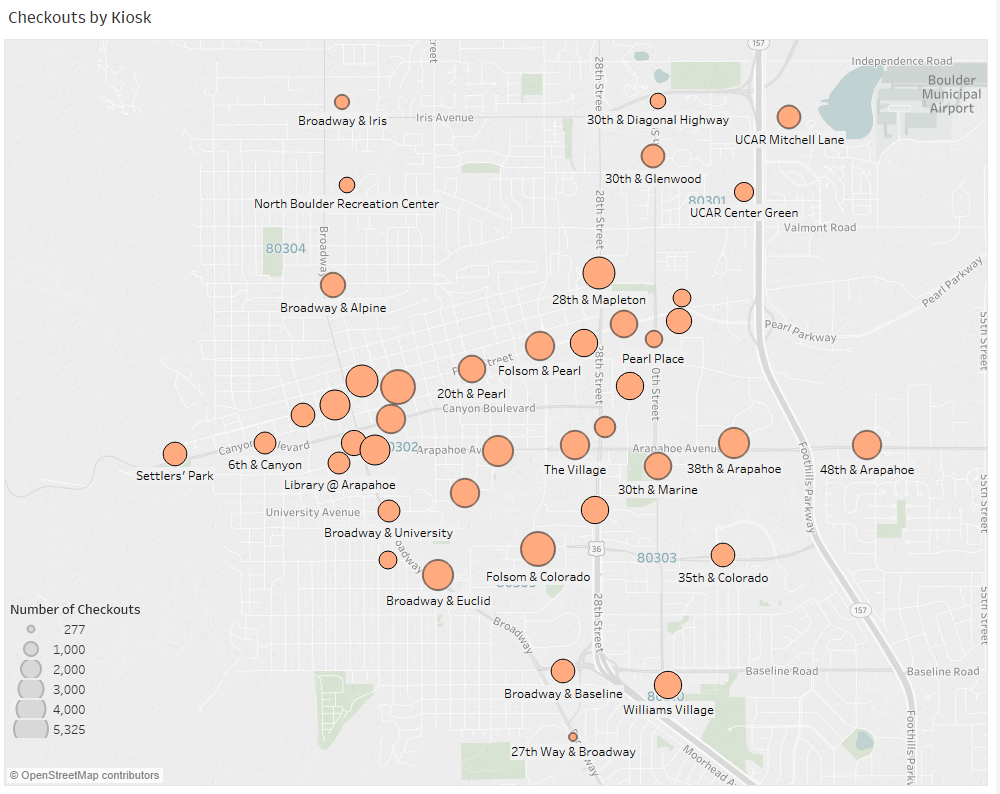

In [283]:
from IPython.display import Image
image = Image('figures/Figure 2.png')
image

### Most Popular Return Kiosks

In [284]:
# Most popular Return Kiosks
mostPopular = dF.groupby('Return_Kiosk').size().sort_values(ascending=False)

In [285]:
mostPopular.head(10)

Return_Kiosk
15th & Pearl                 4692
28th & Mapleton              4282
13th & Spruce                4057
21st & Arapahoe              3943
13th & Arapahoe              3708
Folsom & Pearl               3491
11th & Pearl                 3464
48th & Arapahoe              3356
The Village                  3220
Twenty Ninth Street North    3156
dtype: int64

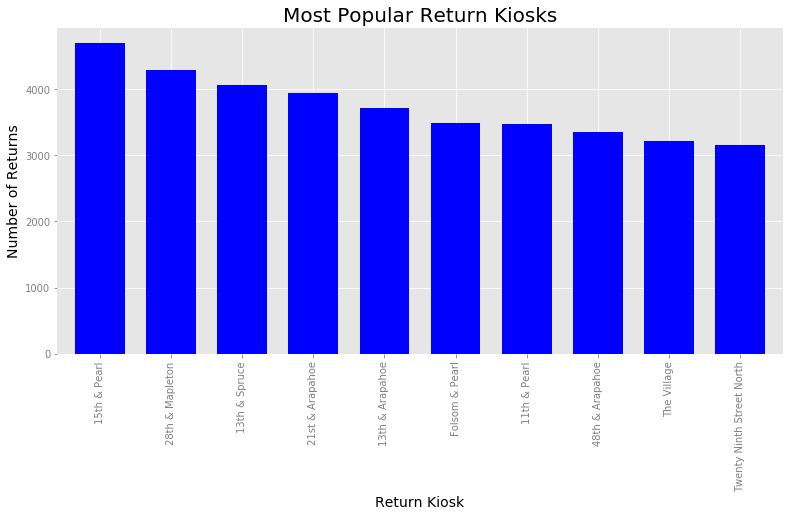

In [286]:
# plot the results
ax = dF.groupby('Return_Kiosk').size().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title("Most Popular Return Kiosks", fontsize = 20)
plt.xlabel('Return Kiosk', fontsize = 14)
plt.ylabel('Number of Returns', fontsize = 14)
plt.grid(color='w', linestyle='solid')
plt.show()

### Map of Return Kiosk Popularity

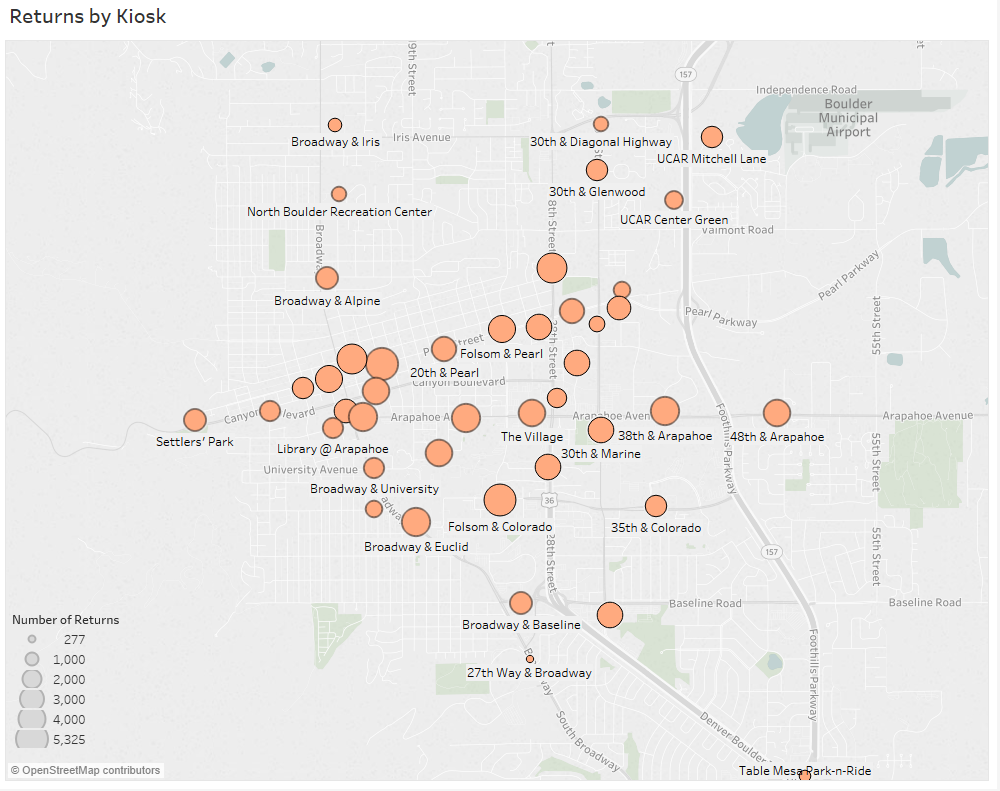

In [287]:
image = Image('figures/Figure 3.png')
image

### Least Popular Checkout Kiosks

In [288]:
# Least popular Checkout Kiosks
leastPopular = dF.groupby('Checkout_Kiosk').size().sort_values(ascending=False)

In [289]:
leastPopular.tail(10)

Checkout_Kiosk
UCAR Center Green                  1379
13th & College                     1317
Boulder Junction                   1251
North Boulder Recreation Center    1012
Pearl Place                        1006
30th & Diagonal Highway             938
Broadway & Iris                     873
Table Mesa Park-n-Ride              506
27th Way & Broadway                 257
Gunbarrel North                     160
dtype: int64

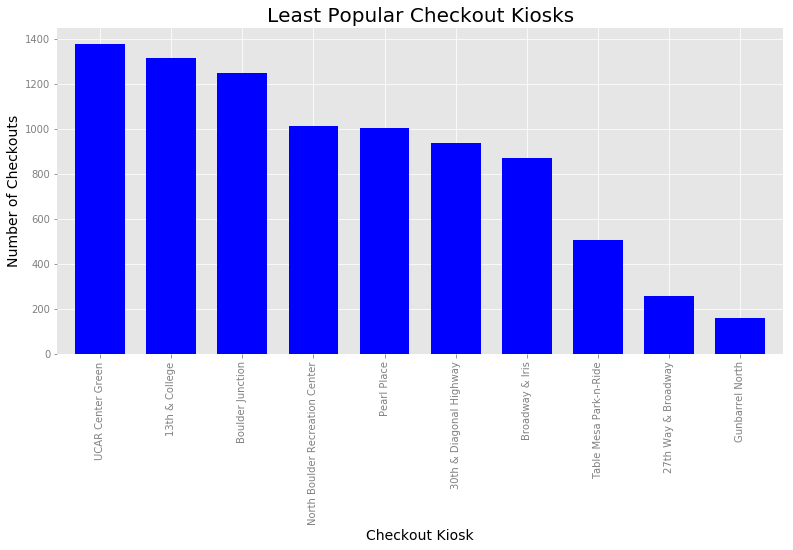

In [290]:
# plot the results
ax = dF.groupby('Checkout_Kiosk').size().sort_values(ascending=False).tail(10).plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title("Least Popular Checkout Kiosks", fontsize = 20)
plt.xlabel('Checkout Kiosk', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

### Least Popular Return Kiosks

In [291]:
# Least popular Return Kiosks
leastPopular = dF.groupby('Return_Kiosk').size().sort_values(ascending=False)

In [292]:
leastPopular.tail(10)

Return_Kiosk
Broadway & University              1210
Boulder Junction                   1146
Pearl Place                        1132
North Boulder Recreation Center     953
13th & College                      922
30th & Diagonal Highway             880
Broadway & Iris                     756
Table Mesa Park-n-Ride              475
27th Way & Broadway                 257
Gunbarrel North                     166
dtype: int64

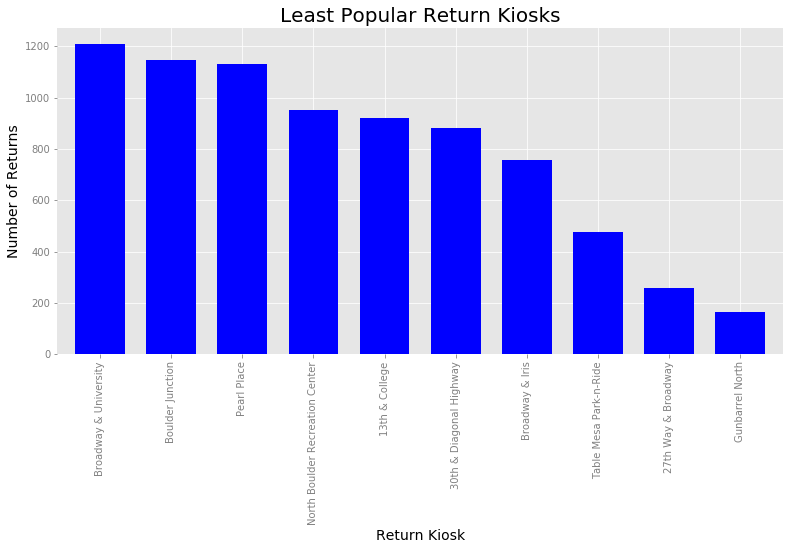

In [293]:
# plot the results
ax = dF.groupby('Return_Kiosk').size().sort_values(ascending=False).tail(10).plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title("Least Popular Return Kiosks", fontsize = 20)
plt.xlabel('Return Kiosk', fontsize = 14)
plt.ylabel('Number of Returns', fontsize = 14)
plt.show()

In [294]:
dF.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Time,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance
0,Boulder B-cycle,R1094717,Annual,913,2017-01-01,00:08:00,13th & Spruce,2017-01-01,00:13:00,Broadway & Alpine,5,0.505
1,Boulder B-cycle,R1066072,Annual,938,2017-01-01,00:08:00,13th & Spruce,2017-01-01,00:13:00,Broadway & Alpine,5,0.505
2,Boulder B-cycle,R1004330,Annual,745,2017-01-01,00:15:00,11th & Pearl,2017-01-01,00:29:00,11th & Pearl,14,0.935


In [295]:
dF.rename(columns = {'Checkout_Time' : 'Checkout_Hour'}, inplace = True)

### Convert Checkout Time to Checkout_Hour

In [296]:
dF['Checkout_Hour'] = dF['Checkout_Hour'].map(lambda x: x[:2]).astype(int)

In [297]:
dF.head(3)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Hour,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance
0,Boulder B-cycle,R1094717,Annual,913,2017-01-01,0,13th & Spruce,2017-01-01,00:13:00,Broadway & Alpine,5,0.505
1,Boulder B-cycle,R1066072,Annual,938,2017-01-01,0,13th & Spruce,2017-01-01,00:13:00,Broadway & Alpine,5,0.505
2,Boulder B-cycle,R1004330,Annual,745,2017-01-01,0,11th & Pearl,2017-01-01,00:29:00,11th & Pearl,14,0.935


### Ridership by Calendar and Clock Variables

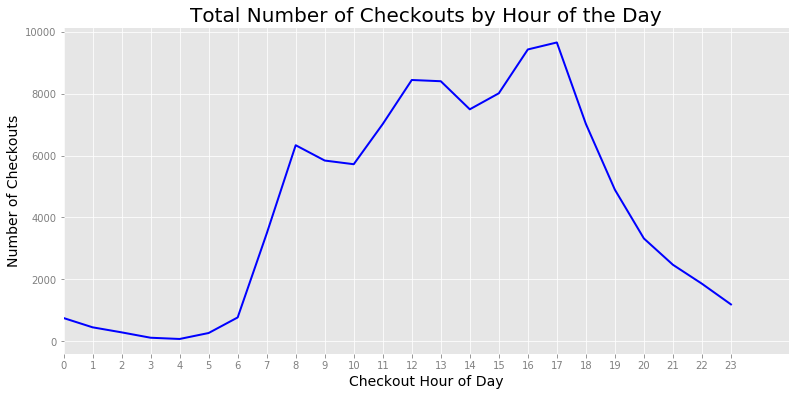

In [298]:
# plot the results
ax = dF.groupby('Checkout_Hour').size().plot(kind='line', figsize=(13,6), 
                color='blue', xlim=(0,25))
plt.title('Total Number of Checkouts by Hour of the Day', fontsize = 20)
plt.xlabel('Checkout Hour of Day', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.xticks(np.arange(0, 24, 1.0))
plt.show()

In [299]:
dH = dF.groupby(['Checkout_Hour']).mean()

In [300]:
dH.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 0 to 23
Data columns (total 2 columns):
Trip_Duration    24 non-null float64
Trip_Distance    24 non-null float64
dtypes: float64(2)
memory usage: 576.0 bytes


In [301]:
# Drop columns that are not relevant
dH.drop(['Trip_Duration'], axis = 1, inplace = True)

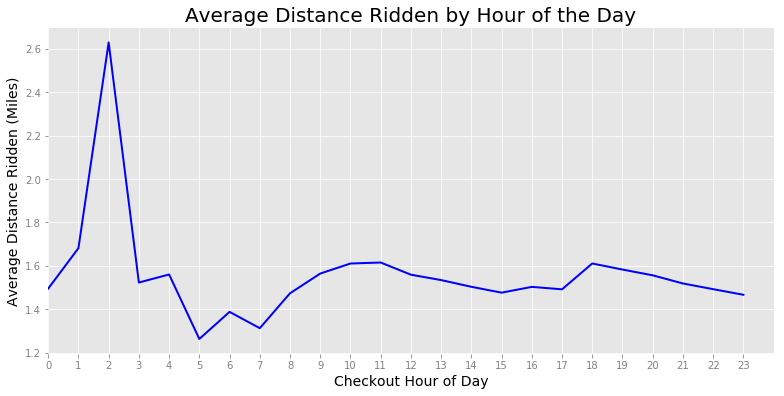

In [302]:
ax = dH.plot(kind='line', figsize=(13,6), 
                color='blue', xlim=(0,24))
plt.title('Average Distance Ridden by Hour of the Day', fontsize = 20)
plt.xlabel('Checkout Hour of Day', fontsize = 14)
plt.ylabel('Average Distance Ridden (Miles)', fontsize = 14)
plt.xticks(np.arange(0, 24, 1.0))
ax.legend().set_visible(False)
plt.show()

### Ridership by Hour and Weekday

#### Create Checkout_Weekday Column in Weather dataframe

In [303]:
# Create a new column called Checkout_WeekDay
dF['Checkout_WeekDay'] = pd.DatetimeIndex(dF['Checkout_Date']).weekday

In [304]:
dMon = dF.where(dF['Checkout_WeekDay'] == 0)
dTue = dF.where(dF['Checkout_WeekDay'] == 1)
dWed = dF.where(dF['Checkout_WeekDay'] == 2)
dThu = dF.where(dF['Checkout_WeekDay'] == 3)
dFri = dF.where(dF['Checkout_WeekDay'] == 4)
dSat = dF.where(dF['Checkout_WeekDay'] == 5)
dSun = dF.where(dF['Checkout_WeekDay'] == 6)

In [305]:
axMon = dMon.groupby('Checkout_Hour').size()
axTue = dTue.groupby('Checkout_Hour').size()
axWed = dWed.groupby('Checkout_Hour').size()
axThu = dThu.groupby('Checkout_Hour').size()
axFri = dFri.groupby('Checkout_Hour').size()
axSat = dSat.groupby('Checkout_Hour').size()
axSun = dSun.groupby('Checkout_Hour').size()

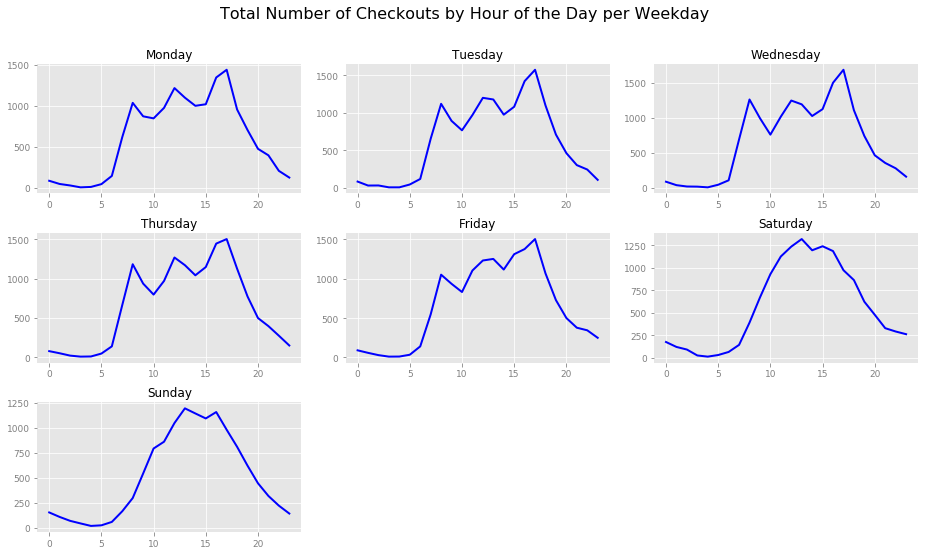

In [306]:
# plot the results
plt.figure()
plt.figure(figsize=(13,10))
plt.suptitle('Total Number of Checkouts by Hour of the Day per Weekday', fontsize=16)

plt.subplot(4,3,1)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Monday', fontsize=12)
plt.plot(axMon,'b-')

plt.subplot(4,3,2)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Tuesday', fontsize=12)
plt.plot(axTue,'b-')

plt.subplot(4,3,3)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Wednesday', fontsize=12)
plt.plot(axWed,'b-')

plt.subplot(4,3,4)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Thursday', fontsize=12)
plt.plot(axThu,'b-')

plt.subplot(4,3,5)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)  
plt.title('Friday', fontsize=12)
plt.plot(axFri,'b-')

plt.subplot(4,3,6)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Saturday', fontsize=12)
plt.plot(axSat,'b-')

plt.subplot(4,3,7)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Sunday', fontsize=12)
plt.plot(axSun,'b-')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig = plt.gca()

### Ridership by Month

#### Create Checkout_Month column in Trips dataframe

In [307]:
# Create a new column called Checkout_Month
dF['Checkout_Month'] = pd.DatetimeIndex(dF['Checkout_Date']).month

In [308]:
dM = dF.groupby(['Checkout_Month'])

In [309]:
dM.size()

Checkout_Month
1      3756
2      4769
3      7515
4      7477
5      8904
6     12400
7     13945
8     13115
9     10985
10     9025
11     6474
12     4917
dtype: int64

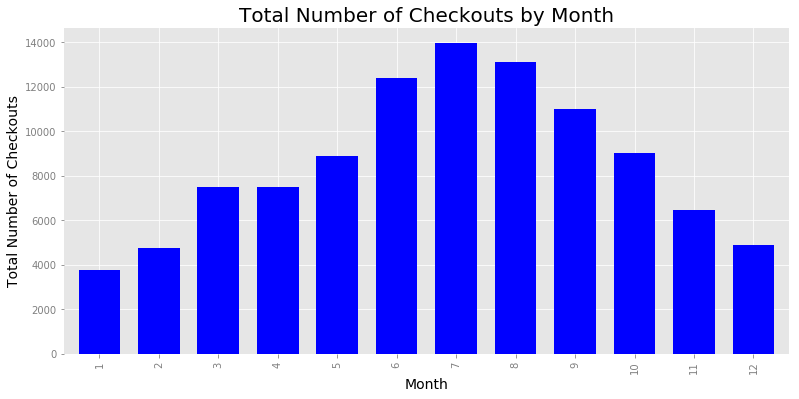

In [310]:
# plot the results
ax = dF.groupby('Checkout_Month').size().plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title('Total Number of Checkouts by Month', fontsize = 20)
plt.xlabel('Month', fontsize = 14)
plt.ylabel('Total Number of Checkouts', fontsize = 14)
plt.show()

## Merging with Weather

### Merge Daily Weather Data with Trips DataFrame

In [311]:
dW = pd.read_csv("data/Boulder_2017_Daily_Weather_Forecast.csv")

In [312]:
dW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 9 columns):
Date                      365 non-null object
cloudCover                365 non-null float64
apparentTemperatureMax    365 non-null float64
apparentTemperatureMin    365 non-null float64
temperatureMax            365 non-null float64
temperatureMin            365 non-null float64
windSpeed                 365 non-null float64
humidity                  365 non-null float64
visibility                365 non-null float64
dtypes: float64(8), object(1)
memory usage: 25.7+ KB


In [313]:
dW.head(3)

,Date,cloudCover,apparentTemperatureMax,apparentTemperatureMin,temperatureMax,temperatureMin,windSpeed,humidity,visibility
0,2017-01-01,0.140,38.100,13.050,40.040,20.420,1.660,0.570,9.940
1,2017-01-02,0.130,42.830,10.830,42.830,18.190,0.850,0.680,9.740
2,2017-01-03,0.260,26.150,4.790,26.150,13.580,0.630,0.790,7.510


In [314]:
dW.isnull().values.any()

False

In [315]:
dW['Date'] = pd.to_datetime(dW['Date'])

In [316]:
dW.sort_values(['Date'], inplace=True)

In [317]:
dF = pd.merge(dF, dW, how='left', left_on=['Checkout_Date'], right_on=['Date'])

In [318]:
dF.shape

(103282, 23)

In [319]:
dF.isnull().values.any()

False

In [320]:
dF.drop(['Date'], axis = 1, inplace = True)

In [321]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103282 entries, 0 to 103281
Data columns (total 22 columns):
User_Program              103282 non-null object
User_ID                   103282 non-null object
Membership_Type           103282 non-null object
Bike_Number               103282 non-null object
Checkout_Date             103282 non-null datetime64[ns]
Checkout_Hour             103282 non-null int32
Checkout_Kiosk            103282 non-null object
Return_Date               103282 non-null datetime64[ns]
Return_Time               103282 non-null object
Return_Kiosk              103282 non-null object
Trip_Duration             103282 non-null int64
Trip_Distance             103282 non-null float64
Checkout_WeekDay          103282 non-null int64
Checkout_Month            103282 non-null int64
cloudCover                103282 non-null float64
apparentTemperatureMax    103282 non-null float64
apparentTemperatureMin    103282 non-null float64
temperatureMax            103282 non-nul

### Ridership by Day

Plot above shows temperature affects ridership. Daily temperatures in the 70s to 80s result in the highest ridership while temperatures 35F and below result in the lowest ridership. Also, ridership is high on weekends (Sunday, labeled as 6 and Saturday, labeled as 5) and during the months between May and June. Conversely, the winter months (December to February) have the lowest ridership unless the temperature is favorable on those days, which is typical of Colorado.

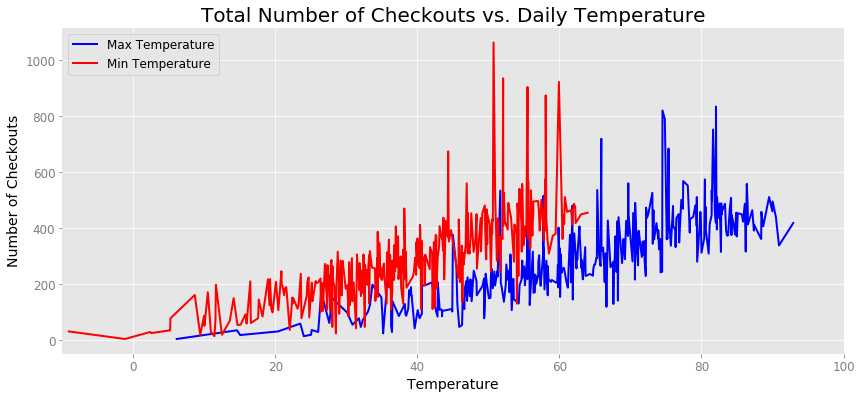

In [322]:
ax = dF.groupby('temperatureMax').size().plot(kind='line', figsize=(13,6), 
                color='blue', label='Max Temperature', fontsize=12, xlim=(-10,100))
ax = dF.groupby('temperatureMin').size().plot(kind='line', figsize=(14,6), 
                color='red', label='Min Temperature', fontsize=12, xlim=(-10,100))
plt.title('Total Number of Checkouts vs. Daily Temperature', fontsize = 20)
plt.xlabel('Temperature', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.legend(loc=2, fontsize='large')
plt.show()

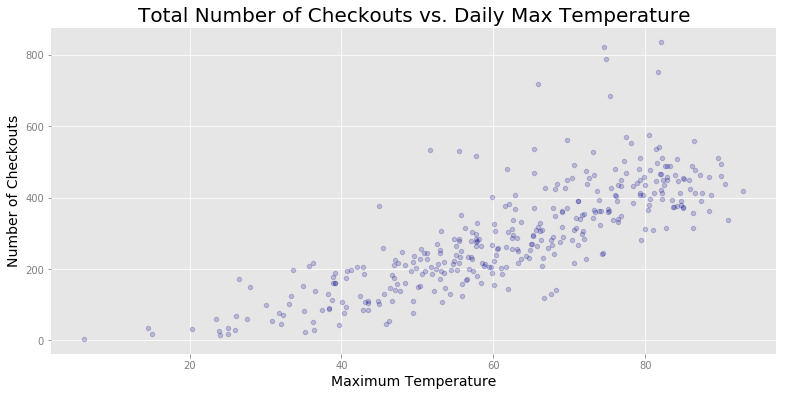

In [323]:
ax = dF.groupby(['temperatureMax']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()
ax.plot(kind='scatter', x='temperatureMax', y='Number_Of_Checkouts', alpha=0.2, figsize=(13,6), color='DarkBlue')
plt.title('Total Number of Checkouts vs. Daily Max Temperature', fontsize = 20)
plt.xlabel('Maximum Temperature', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

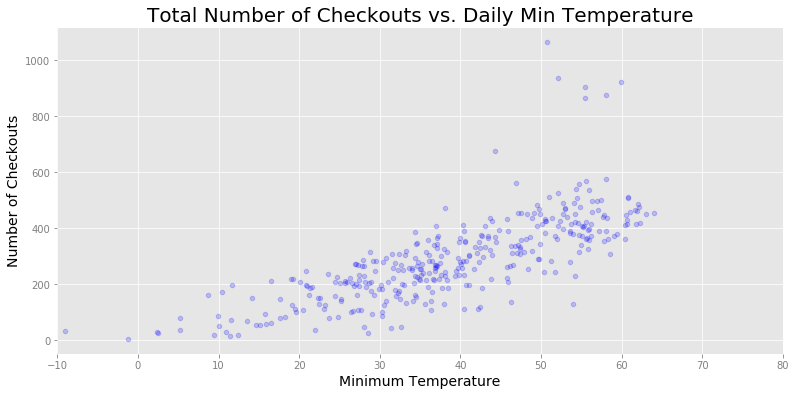

In [324]:
ax = dF.groupby(['temperatureMin']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()
ax.plot(kind='scatter', x='temperatureMin', y='Number_Of_Checkouts', alpha=0.2, figsize=(13,6),
        color='blue', xlim=(-10,80))
plt.title('Total Number of Checkouts vs. Daily Min Temperature', fontsize = 20)
plt.xlabel('Minimum Temperature', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

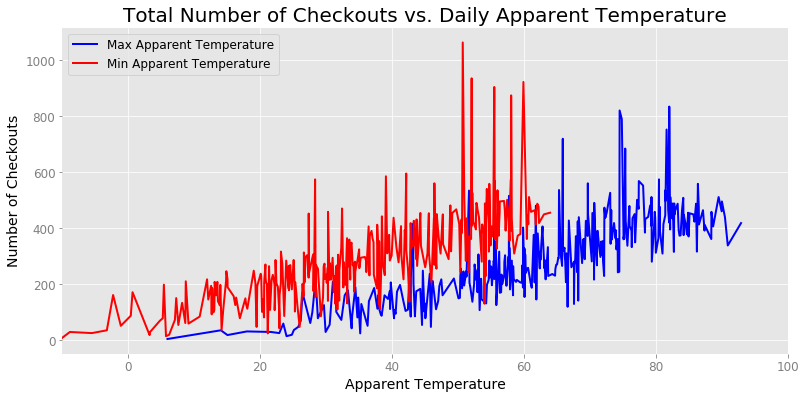

In [325]:
ax = dF.groupby('apparentTemperatureMax').size().plot(kind='line', figsize=(13,6), 
                color='blue', label='Max Apparent Temperature', fontsize=12, xlim=(-10,100))
ax = dF.groupby('apparentTemperatureMin').size().plot(kind='line', figsize=(13,6), 
                color='red', label='Min Apparent Temperature', fontsize=12, xlim=(-10,100))
plt.title('Total Number of Checkouts vs. Daily Apparent Temperature', fontsize = 20)
plt.xlabel('Apparent Temperature', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.legend(loc=2, fontsize='large')
plt.show()

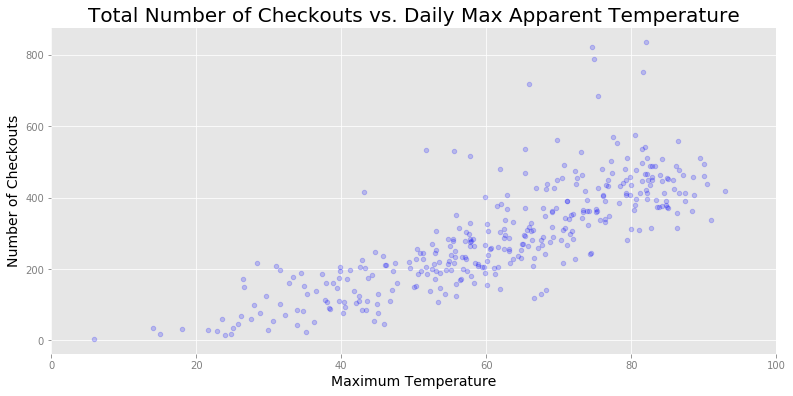

In [326]:
ax = dF.groupby(['apparentTemperatureMax']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()
ax.plot(kind='scatter', x='apparentTemperatureMax', y='Number_Of_Checkouts', alpha=0.2, figsize=(13,6),
        color='blue', xlim=(0,100))
plt.title('Total Number of Checkouts vs. Daily Max Apparent Temperature', fontsize = 20)
plt.xlabel('Maximum Temperature', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

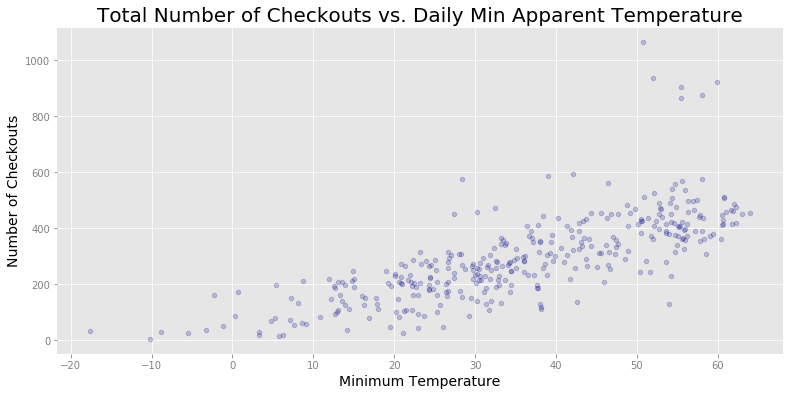

In [327]:
ax = dF.groupby(['apparentTemperatureMin']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()
ax.plot(kind='scatter', x='apparentTemperatureMin', y='Number_Of_Checkouts', alpha=0.2, figsize=(13,6), color='DarkBlue')
plt.title('Total Number of Checkouts vs. Daily Min Apparent Temperature', fontsize = 20)
plt.xlabel('Minimum Temperature', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

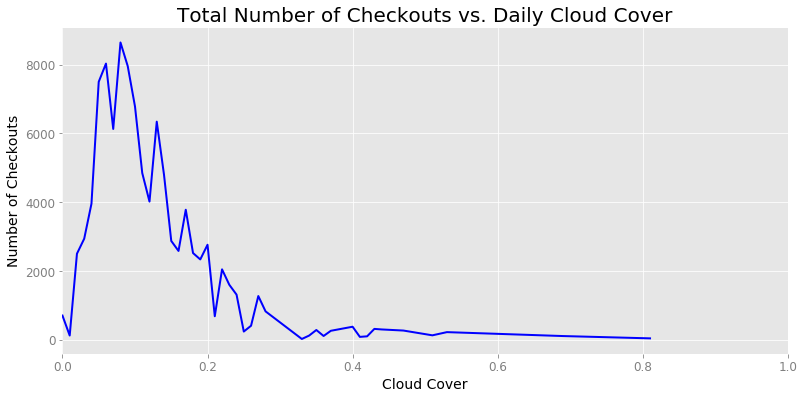

In [328]:
ax = dF.groupby('cloudCover').size().plot(kind='line', figsize=(13,6), 
                color='blue', fontsize=12, xlim=(0,1))
plt.title('Total Number of Checkouts vs. Daily Cloud Cover', fontsize = 20)
plt.xlabel('Cloud Cover', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

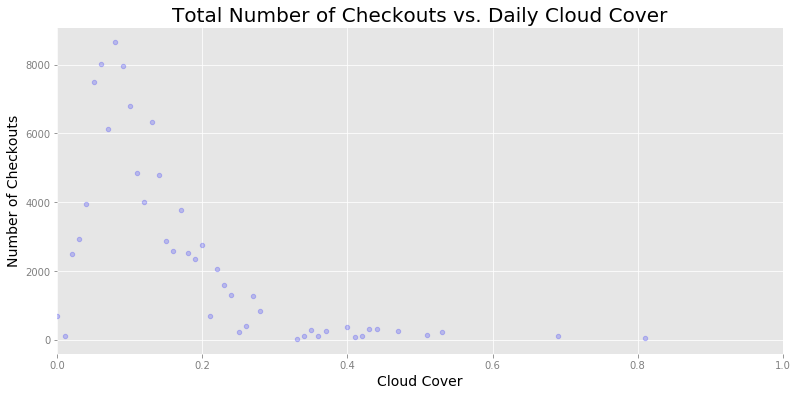

In [329]:
ax = dF.groupby(['cloudCover']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()
ax.plot(kind='scatter', x='cloudCover', y='Number_Of_Checkouts', alpha=0.2, figsize=(13,6),
        color='blue', xlim=(0,1))
plt.title('Total Number of Checkouts vs. Daily Cloud Cover', fontsize = 20)
plt.xlabel('Cloud Cover', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

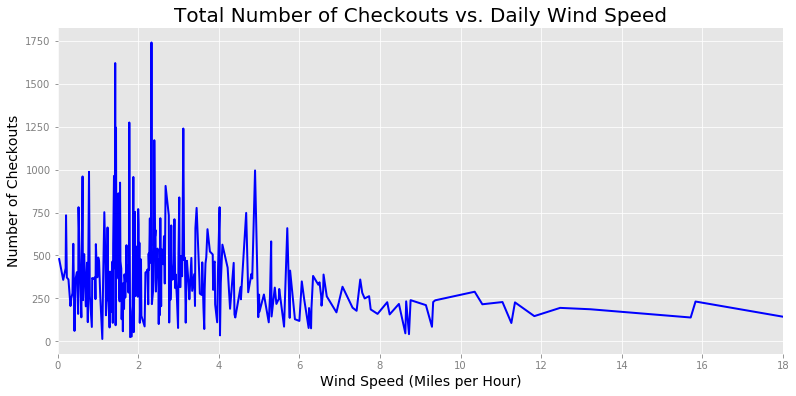

In [330]:
ax = dF.groupby('windSpeed').size().plot(kind='line', figsize=(13,6), 
                color='blue', xlim=(0,18))
plt.title('Total Number of Checkouts vs. Daily Wind Speed', fontsize = 20)
plt.xlabel('Wind Speed (Miles per Hour)', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

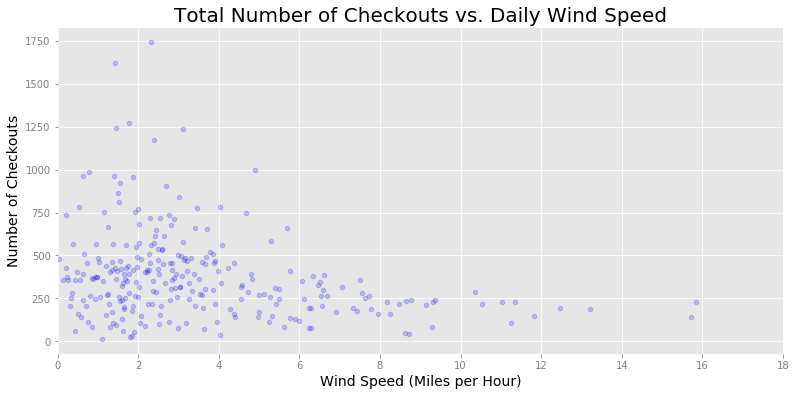

In [331]:
ax = dF.groupby(['windSpeed']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()
ax.plot(kind='scatter', x='windSpeed', y='Number_Of_Checkouts', alpha=0.2, figsize=(13,6),
        color='blue', xlim=(0,18))
plt.title('Total Number of Checkouts vs. Daily Wind Speed', fontsize = 20)
plt.xlabel('Wind Speed (Miles per Hour)', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

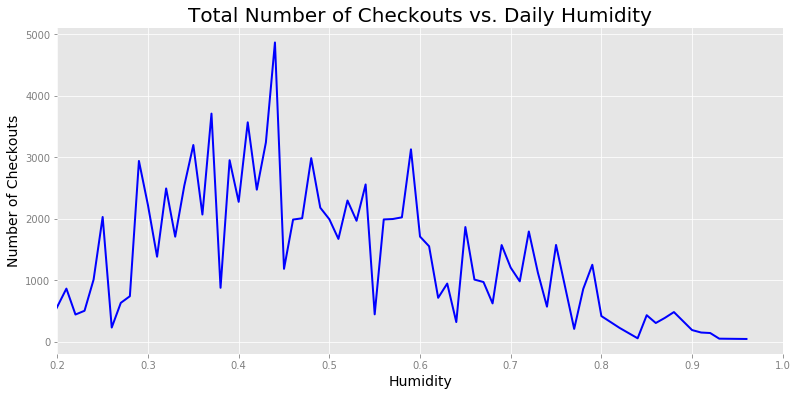

In [332]:
ax = dF.groupby('humidity').size().plot(kind='line', figsize=(13,6), 
                color='blue', xlim=(0.2,1))
plt.title('Total Number of Checkouts vs. Daily Humidity', fontsize = 20)
plt.xlabel('Humidity', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

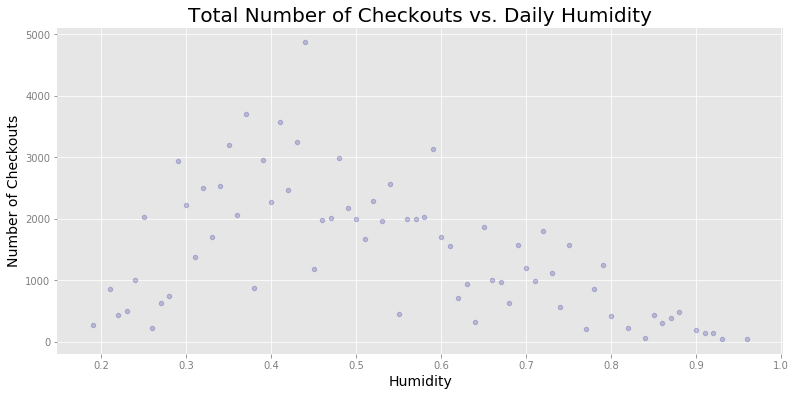

In [333]:
ax = dF.groupby(['humidity']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()
ax.plot(kind='scatter', x='humidity', y='Number_Of_Checkouts', alpha=0.2, figsize=(13,6), color='DarkBlue')
plt.title('Total Number of Checkouts vs. Daily Humidity', fontsize = 20)
plt.xlabel('Humidity', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

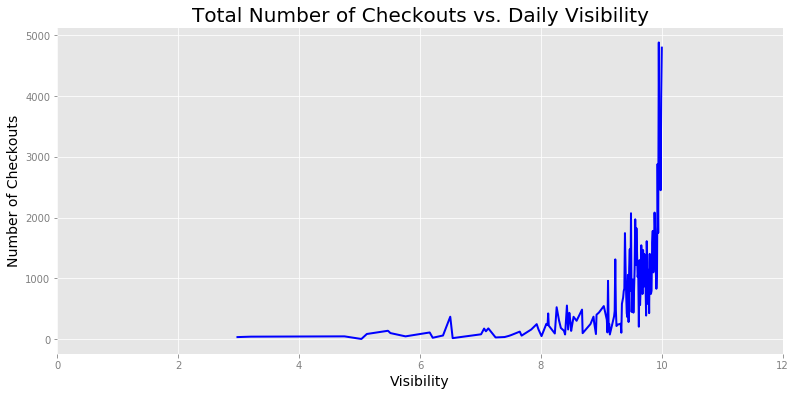

In [334]:
ax = dF.groupby('visibility').size().plot(kind='line', figsize=(13,6), 
                color='blue', xlim=(0,12))
plt.title('Total Number of Checkouts vs. Daily Visibility', fontsize = 20)
plt.xlabel('Visibility', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

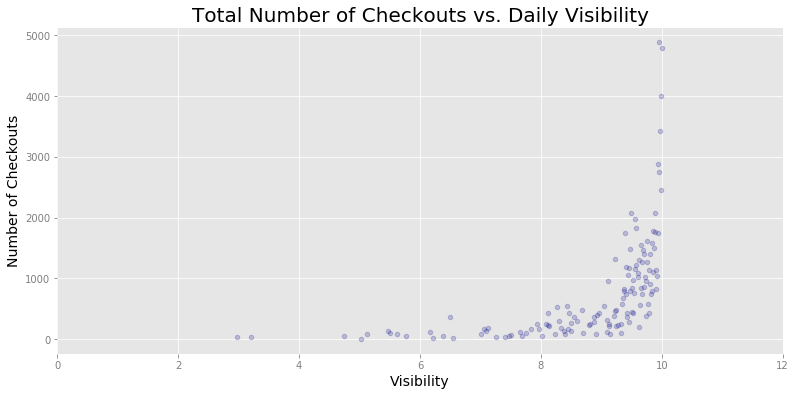

In [335]:
ax = dF.groupby(['visibility']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()
ax.plot(kind='scatter', x='visibility', y='Number_Of_Checkouts', alpha=0.2, figsize=(13,6), color='DarkBlue',
        xlim=(0,12))
plt.title('Total Number of Checkouts vs. Daily Visibility', fontsize = 20)
plt.xlabel('Visibility', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

### Highest Ridership

In [336]:
dHRD = dF.groupby(['Checkout_WeekDay', 'Checkout_Date', 'temperatureMax', 'temperatureMin'])['Checkout_WeekDay']

In [337]:
dHRD.size().sort_values(ascending=False).head(10)

Checkout_WeekDay  Checkout_Date  temperatureMax  temperatureMin
3                 2017-07-27     80.480          58.020            574
5                 2017-08-05     77.420          55.600            568
                  2017-06-24     69.690          46.940            560
4                 2017-06-09     86.380          54.750            558
                  2017-09-08     78.070          50.720            552
2                 2017-06-28     81.830          54.370            540
4                 2017-07-14     81.440          55.990            535
                  2017-08-11     73.080          52.170            526
0                 2017-07-24     89.520          60.770            511
4                 2017-08-18     82.190          50.950            511
Name: Checkout_WeekDay, dtype: int64

### Lowest Ridership

In [338]:
dHRD.size().sort_values(ascending=False).tail(10)

Checkout_WeekDay  Checkout_Date  temperatureMax  temperatureMin
2                 2017-01-04     14.590          5.180             35
4                 2017-01-06     20.380          -9.100            31
6                 2017-12-24     26.020          2.390             29
3                 2017-12-21     36.420          10.920            29
5                 2017-01-07     23.870          2.520             25
0                 2017-01-16     35.170          28.520            24
6                 2017-12-31     25.020          12.470            19
1                 2017-12-26     15.040          9.420             18
0                 2017-12-25     24.000          11.420            14
3                 2017-01-05     6.110           -1.190             4
Name: Checkout_WeekDay, dtype: int64

In [339]:
dF.drop(['apparentTemperatureMax', 'apparentTemperatureMin', 'temperatureMax', 'temperatureMin',
         'cloudCover', 'humidity', 'windSpeed', 'visibility'], axis = 1, inplace = True)

### Merge Hourly Weather with Trips DataFrame

In [340]:
dW = pd.read_csv("data/Boulder_2017_Hourly_Weather_Forecast.csv")

In [341]:
dW.rename(columns = {'Hour': 'Checkout_Hour'}, inplace = True)

In [342]:
dW['Checkout_WeekDay'] = pd.DatetimeIndex(dW['Date']).weekday

In [343]:
dW['Checkout_Month'] = pd.DatetimeIndex(dW['Date']).month

In [344]:
dFW = dF.groupby(['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 
                  'Checkout_Hour']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()

In [345]:
dW['Date'] = pd.to_datetime(dW['Date'])

In [346]:
dT = pd.merge(dW, dFW, how='left', left_on=['Date', 'Checkout_Hour'], 
              right_on=['Checkout_Date', 'Checkout_Hour'])

In [347]:
dT.isnull().values.any()

True

In [348]:
nan_rows = dT[dT.isnull().T.any().T]

In [349]:
dT = dT.drop(dT.index[nan_rows.index])

In [350]:
dT.isnull().values.any()

False

In [351]:
dT.drop(['Date', 'Checkout_WeekDay_y', 'Checkout_Month_y'], axis = 1, inplace = True)
dT.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility',
                     'Checkout_WeekDay_x': 'Checkout_WeekDay', 'Checkout_Month_x': 'Checkout_Month'}, inplace = True)

In [352]:
dT = dT[['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Humidity', 'Wind_Speed', 'Visibility', 'Number_Of_Checkouts']]

### Checkouts vs. Hourly Temperature

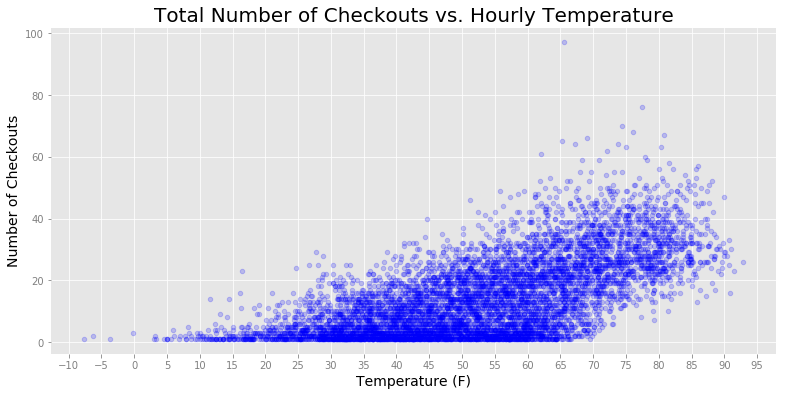

In [353]:
# Pandas scatter plot
dT.plot(kind='scatter', x='Temperature', y='Number_Of_Checkouts', alpha=0.2, color='blue', figsize=(13,6))
plt.title('Total Number of Checkouts vs. Hourly Temperature', fontsize = 20)
plt.xlabel('Temperature (F)', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.xticks(np.arange(-10, 100, 5))
plt.show()

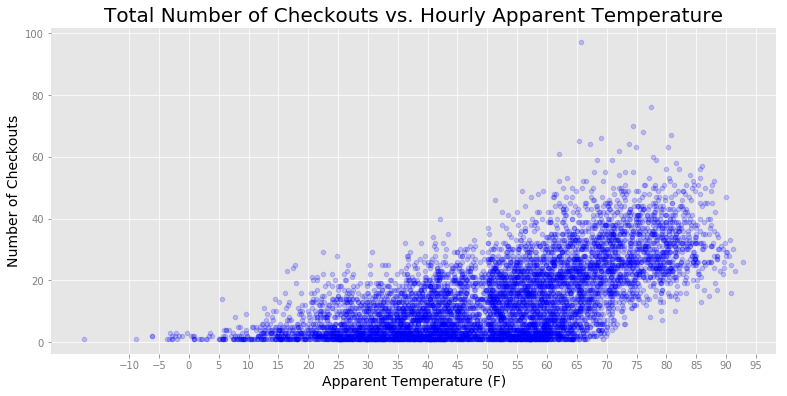

In [354]:
dT.plot(kind='scatter', x='Apparent_Temperature', y='Number_Of_Checkouts', alpha=0.2, color='blue', figsize=(13,6))
plt.title('Total Number of Checkouts vs. Hourly Apparent Temperature', fontsize = 20)
plt.xlabel('Apparent Temperature (F)', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.xticks(np.arange(-10, 100, 5))
plt.show()

### Checkouts vs. Hourly Humidity

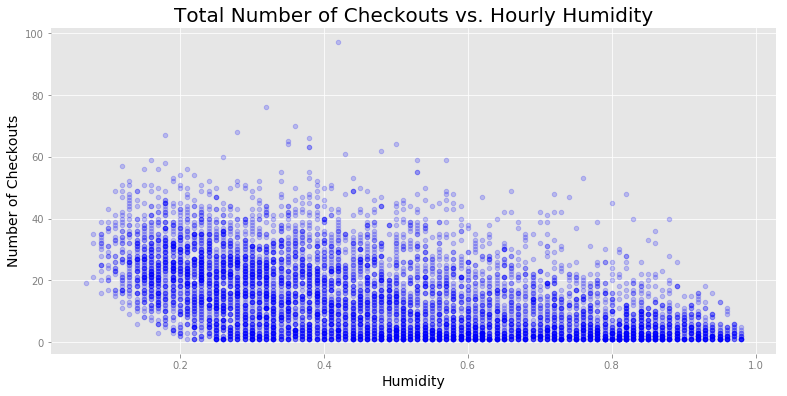

In [355]:
dT.plot(kind='scatter', x='Humidity', y='Number_Of_Checkouts', alpha=0.2, color='blue', figsize=(13,6))
plt.title('Total Number of Checkouts vs. Hourly Humidity', fontsize = 20)
plt.xlabel('Humidity', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

### Checkouts vs. Hourly Cloud Cover

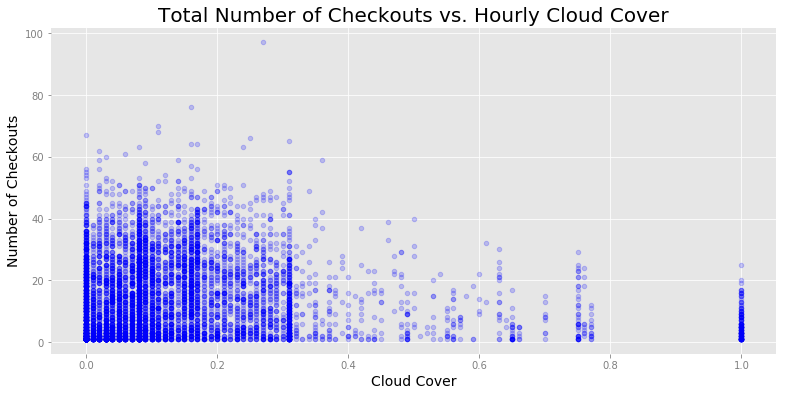

In [356]:
dT.plot(kind='scatter', x='Cloud_Cover', y='Number_Of_Checkouts', alpha=0.2, color='blue', figsize=(13,6))
plt.title('Total Number of Checkouts vs. Hourly Cloud Cover', fontsize = 20)
plt.xlabel('Cloud Cover', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

### Checkouts vs. Hourly Wind Speed

Wind speed significantly impacts ridership. Speeds between 0 and 5 miles per hour are very favorable to renting bikes. Rideship radipdly diminshes at 10 or higher miles per hour.

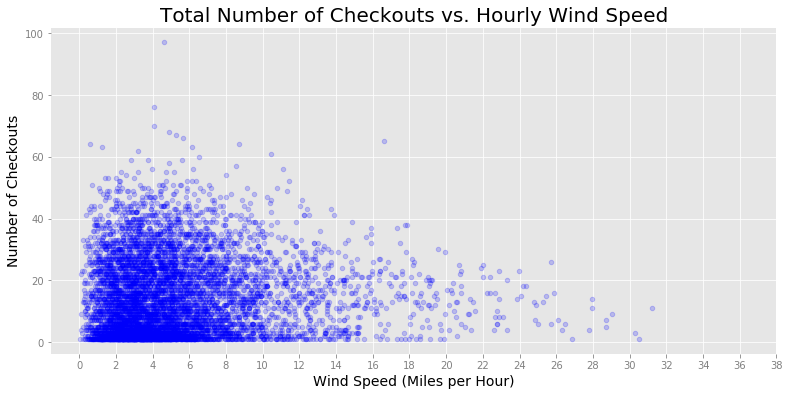

In [357]:
dT.plot(kind='scatter', x='Wind_Speed', y='Number_Of_Checkouts', alpha=0.2, color='blue', figsize=(13,6))
plt.title('Total Number of Checkouts vs. Hourly Wind Speed', fontsize = 20)
plt.xlabel('Wind Speed (Miles per Hour)', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.xticks(np.arange(0, 40, 2))
plt.show()

### Checkouts vs. Hourly Visibility

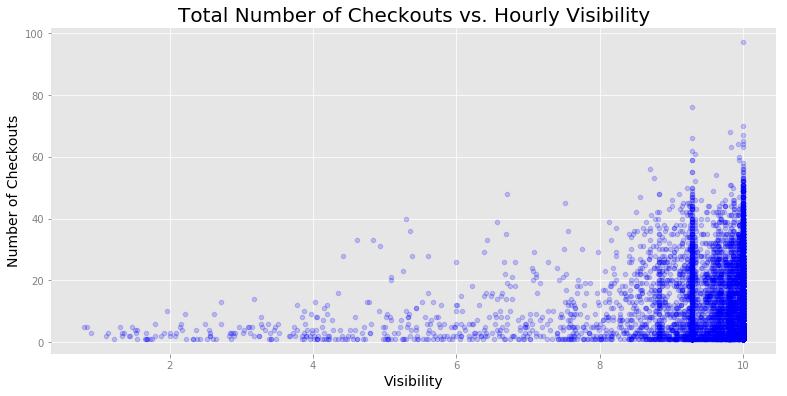

In [358]:
dT.plot(kind='scatter', x='Visibility', y='Number_Of_Checkouts', alpha=0.2, color='blue', figsize=(13,6))
plt.title('Total Number of Checkouts vs. Hourly Visibility', fontsize = 20)
plt.xlabel('Visibility', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

For regression studies, trip durations of 0, 1 and 2 minutes become relevant, so we need to bring these rows back to the Trips dataframe. Maintenance entries are not valid, so we continue to ignore them.

In [359]:
dML.rename(columns = {'Checkout_Time' : 'Checkout_Hour'}, inplace = True)

In [360]:
dML['Checkout_Hour'] = dML['Checkout_Hour'].map(lambda x: x[:2]).astype(int)

In [361]:
# Create a new column called Checkout_WeekDay
dML['Checkout_WeekDay'] = pd.DatetimeIndex(dML['Checkout_Date']).weekday

In [362]:
# Create a new column called Checkout_Month
dML['Checkout_Month'] = pd.DatetimeIndex(dML['Checkout_Date']).month

In [363]:
dML.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106899 entries, 0 to 122330
Data columns (total 13 columns):
User_Program        106899 non-null object
User_ID             106899 non-null object
Membership_Type     106899 non-null object
Bike_Number         106899 non-null object
Checkout_Date       106899 non-null datetime64[ns]
Checkout_Hour       106899 non-null int32
Checkout_Kiosk      106899 non-null object
Return_Date         106899 non-null datetime64[ns]
Return_Time         106899 non-null object
Return_Kiosk        106899 non-null object
Trip_Duration       106899 non-null int64
Checkout_WeekDay    106899 non-null int64
Checkout_Month      106899 non-null int64
dtypes: datetime64[ns](2), int32(1), int64(3), object(7)
memory usage: 11.0+ MB


In [364]:
# save csv file in preparation for use in the Machine Learning phase
dML.to_csv("data/Boulder_2017_Bike_Trip_ML_Data.gz", index=False, compression="gzip")